**Standard Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

import seaborn as sns
sns.set_style('white')

# 1. Simulate sharp waveform

In [54]:
def periodic_gaussians(T, period, gauss_std,
                       Fs = 1000, delta_jitter = None, delta_prob = None,
                       amplitude_envelope = False, amplitude_envelope_filt_kwargs = {}):
    """Simulate a signal that is periodic gaussians
    
    Parameters
    ----------
    T : float
        length of time
    period
    gauss_std
    Fs
    delta_jitter
    amplitude_envelope : bool
        if True, the gaussian periodic gaussian is modulated by an amplitude envelope.
        This amplitude envelope is obtained by bandpass-filtering white noise 
    amplitude_envelope_filt_kwargs : dict
    
    Returns
    -------
    t
    lfp
    
    """
    
    # Process input
    dt = 1/float(Fs)
    t = np.arange(0,T,dt)
    N_samples = len(t)
    
    # Generate delta train
    delta_train = periodic_delta(N_samples, int(period*Fs), delta_jitter = delta_jitter, delta_prob = delta_prob)
    
    # Generate Gaussian
    gauss_len_time_half = gauss_std*3
    gauss_t = np.arange(-gauss_len_time_half,gauss_len_time_half+dt,dt)
    gauss_curve = gaussian(gauss_t, 0, gauss_std)
    
    # Convolve Gaussian with delta train
    lfp = np.convolve(delta_train, gauss_curve, mode='same') 
    # Make minimum -1 and max 1. Then subtract mean
    Ntaps = len(gauss_t)
    lfp = (lfp - np.min(lfp[Ntaps:-Ntaps]))/(np.max(lfp[Ntaps:-Ntaps])-np.min(lfp[Ntaps:-Ntaps]))*2 - 1
    # Subtract mean
    lfp -= np.mean(lfp)
    return t, lfp


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
    
def periodic_delta(N_samples, period, delta_jitter = None, delta_prob = None):
    """Simulate an oscillatory point process (1 event every period)
    noise is the standard deviation of the distribution of inter-spike-intervals (in samples)"""
    if delta_prob is None:
        delta_prob = 1
    
    x = np.zeros(N_samples)
    spike_time = period-1
    while spike_time < N_samples:
        if np.random.rand(1)[0] < delta_prob:
            x[spike_time] = 1
        if delta_jitter is not None:
            spike_time += period + int(np.random.randn()*delta_jitter)
        else:
            spike_time += period
    return x


def simbrown(N):
    """Simulate a brown noise signal (power law distribution 1/f^2)
    with N samples"""
    wn = np.random.randn(N)
    return np.cumsum(wn)
    

def simfiltonef(T, f_range, Fs, N, samp_buffer = 10000):
    """ Simulate a band-pass filtered signal with 1/f^2 
    Input suggestions: f_range=(2,None), Fs=1000, N=1000
    
    Parameters
    ----------
    T : float
        length of time of simulated oscillation
    Fs : float
        oscillation sampling rate
    f_range : 2-element array (lo,hi)
        frequency range of simulated data
        if None: do not filter
    N : int
        order of filter
    """

    if f_range is None:
        # Do not filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs))
        return brownN
    elif f_range[1] is None:
        # High pass filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs+N*2))
        # Filter
        nyq = Fs / 2.
        if N % 2 == 0:
            print('NOTE: Increased high-pass filter order by 1 in order to be odd')
            N += 1

        taps = sp.signal.firwin(N, f_range[0] / nyq, pass_zero=False)
        brownNf = sp.signal.filtfilt(taps, [1], brownN)
        return brownNf[N:-N]

    else:
        # Bandpass filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs+N*2))
        # Filter
        nyq = Fs / 2.
        taps = sp.signal.firwin(N, np.array(f_range) / nyq, pass_zero=False)
        brownNf = sp.signal.filtfilt(taps, [1], brownN)
        return brownNf[N:-N]
    

def norm01(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

# Simulate nonsinusoidal oscillation

In [93]:
# SImulation parameters
Fs = 1000
delta_jitter = 6
delta_prob = .6
T = 30
f1 = 10
f1bw = 2
f1_range = (f1-f1bw,f1+f1bw)
period = 1/float(f1)
gauss_std_1 = .01
gauss_std_2 = .02

In [94]:
np.random.seed(1)
t, x_gauss_1 = periodic_gaussians(T, period, gauss_std_1,
                       Fs = Fs, delta_jitter = delta_jitter, delta_prob = delta_prob)
t, x_gauss_2 = periodic_gaussians(T, period, gauss_std_2,
                       Fs = Fs, delta_jitter = delta_jitter, delta_prob = delta_prob)

# Simulate 1/f noise

In [95]:
Ntaps = 500
randseed = 0
brown_bandpass = (2,200)
x_brown = simfiltonef(T, brown_bandpass, Fs, Ntaps)
x_brown = norm01(x_brown)

# Viz symmetric and asymmetric oscillation

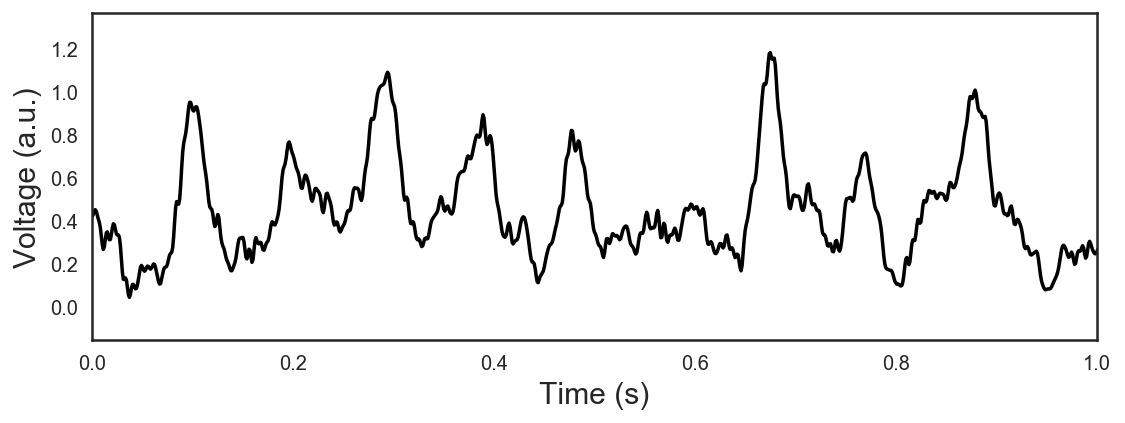

In [99]:
# Oscillation and noise is neural signal
x_gauss_weight = .3
x1 = x_gauss_1*x_gauss_weight + x_brown
x2 = x_gauss_2*x_gauss_weight + x_brown

plt.figure(figsize=(9,3))
plt.plot(t,x1, 'k-')
# plt.plot(t,x_gauss_1*x_gauss_weight, 'b-', alpha=.5)
# plt.plot(t,x_brown, 'r-', alpha=.5)
plt.xlim((0,1))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (a.u.)', size=15)

# Compute PSD

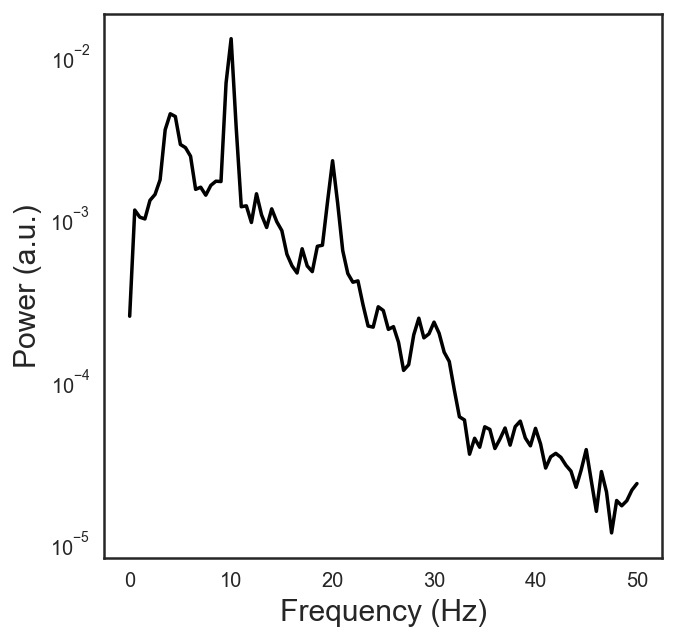

In [97]:
from neurodsp import spectral
f, psd = spectral.psd(x1, Fs, nperseg = Fs*2)
flim = (0,50)
fidxs = np.logical_and(f >= flim[0], f <= flim[1])
f = f[fidxs]
psd = psd[fidxs]

plt.figure(figsize=(5,5))
plt.semilogy(f, psd, 'k')
plt.xlabel('Frequency (Hz)', size=15)
plt.ylabel('Power (a.u.)', size=15)